# Chapter 7 Ensemble Learning and Random Forests

Ensemble methods use multiple models and aggregates all of their predictions in order to make a final decision. Ther are many ways of doing this. We will go over voting classifiers, bagging, boosting, and stacking methods, and random forests.

## Voting Classifiers

Imagine you have trained multiple classifiers. A hard voting classifier or majority voting classifier will look at the predictions made by these classifiers for a particular instance and pick the class that is predicted most frequently. This method can achieve high accuracy even if the individual classifiers don't perform very well, assuming a large number of independent/diverse classifiers (usually we're not quite so lucky). To see why, imagine you have a coin that has a 51% chance of landing heads. The more you flip this coin, the higher the the probability of having a majority of heads becomes. In this analogy, every coin flip represents a different classifier and flipping heads is equivalent to predicting the correct class. Let's create a voting classifier using three different models on a make moons dataset.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
                estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
                voting='hard'
)

voting_clf.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', RandomFo...f', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [3]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.888
VotingClassifier 0.888


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: Fu

We can also a soft voting classifier by replacing the voting parameter in VotingClassifier. This method averages the probability of an instance being in a certain class across classifiers, and picks the class with the highest probability. Obviously, this method requires that the classifiers be able to output probabilities. 

In [4]:
log_clf = LogisticRegression(solver="liblinear")
rnd_clf = RandomForestClassifier(n_estimators=10)
svm_clf = SVC(gamma="auto", probability=True)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.888
VotingClassifier 0.904


We can see in both cases the voting classifier performs better than any individual classifier.

## Bagging and Pasting

Instead of using different classifiers, we can use bagging and pasting methods and train the same classifier on random subsets of our data, either with replacement (bagging) or without (pasting). Once we've produced different models for the subsetst of training data, we can choose how to aggregate their predictions (typically majority voting for classification and averaging for regression).

In [5]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
            # 500 decision trees trained on 100-sample subsets
            DecisionTreeClassifier(), n_estimators=500,
            # boostrap=False for pasting
            max_samples=100, bootstrap=True, n_jobs=-1
)
bag_clf.fit(X_train, y_train)
# Uses soft voting if possible, hard otherwise
y_pred = bag_clf.predict(X_test)

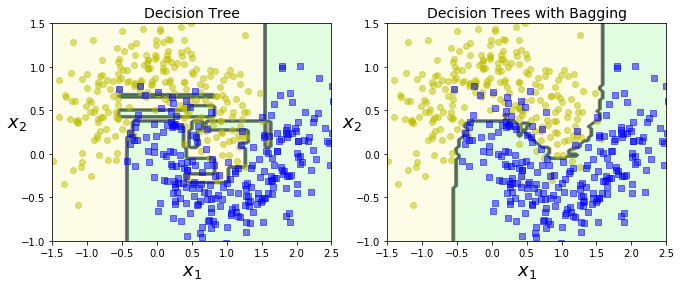

In [6]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)

plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14);

### Out-of-Bag Evaluation

By default, BaggingClassifier will take a sample equal to the size of the training set, with replacement. This means that there will usually be some instances that aren't sampled, referred to as out-of-bag (oob) instances. These can be used for model evaluation. BaggingClassifier will output the average oob score over each trained model.  

In [7]:
bag_clf = BaggingClassifier(
            DecisionTreeClassifier(), n_estimators=500,
            bootstrap=True, n_jobs=-1, oob_score=True
)
bag_clf.fit(X_train, y_train)
print(f'oob score: {bag_clf.oob_score_}')

y_pred = bag_clf.predict(X_test)
print(f'test accuracy: {accuracy_score(y_pred, y_test)}')

oob score: 0.9013333333333333
test accuracy: 0.904


### Random Patches and Random Subspaces

BaggingClassifier can also sample features instead of just data using hyperparameters. Similarly to sampling instances, we can control the number of features and whether we sample with replacement. Sampling both the data and features is called the random patches method while using all the data and sampling features is called the random subspaces method. 

In general, if a method leads to more predictor diversity, such as bagging or feature sampling, the resulting model will have a lower variance at the cost of a slightly higher bias.  

## Random Forests

Instead of using BaggingClassifier with a Decision Tree classifier, we can use the RandomForestClassifier, which is optimized for bagging with decision trees. 

In [8]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)
accuracy_score(y_pred_rf, y_test)

0.912

### Feature Importance

We can also use RandomForestClassifier to get a ranking of feature importances, which are calculated by the average depth at which a feature appears across decision trees (more important features appear closer to the root of the tree). 

In [9]:
from sklearn.datasets import load_iris

iris = load_iris()

rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])

for feature, importance in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(f'{feature}: {importance}')

sepal length (cm): 0.10036671058579642
sepal width (cm): 0.023190481643223976
petal length (cm): 0.4256880134246773
petal width (cm): 0.4507547943463021


## Boosting

Boosting is an ensemble method which combines predictors sequentially, each one trying to improve upon the errors of the previous. Two of the most popular boosting methods are AdaBoost and Gradient Boosting.

### AdaBoost

AdaBoost works by assigning a weight to each instance, where instances that were misclassified by a certain predictor are given a higher weight for the next predictor. The learning rate hyperparameter determines how much the weights are updated for each new predictor. A higher learning rate means a larger magnitude of change, or a more complex model. When AdaBoost is making its final decision, it also weighs the contribution of each predictor by its accuracy. 

sklearn uses the SAMME algorithm when running AdaBoost which allows for multiclass classifications and reduces to AdaBoost for binary classification problems. If the classifier can output probabilities, it can also use the SAMME.R algorithm which usually performs better. 

In [10]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
            DecisionTreeClassifier(max_depth=1), n_estimators=200,
            algorithm='SAMME.R', learning_rate=0.5
)
ada_clf.fit(X_train, y_train)
y_pred = ada_clf.predict(X_test)
accuracy_score(y_pred, y_test)

0.896

### Gradient Boosting

In Gradient Boosting, each predictor tries to output the residuals of the previous predictor, and then sums up the output of all these predictors for its final output. We can manually create a gradient boosting regressor using decision tree regressors to visualize the way that this method works. 

In [11]:
from sklearn.tree import DecisionTreeRegressor

X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

# Fit initial predictor to data
tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

# Calculate residuals
y2 = y - tree_reg1.predict(X)
# Fit second predictor to residuals
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

# Repeat process
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

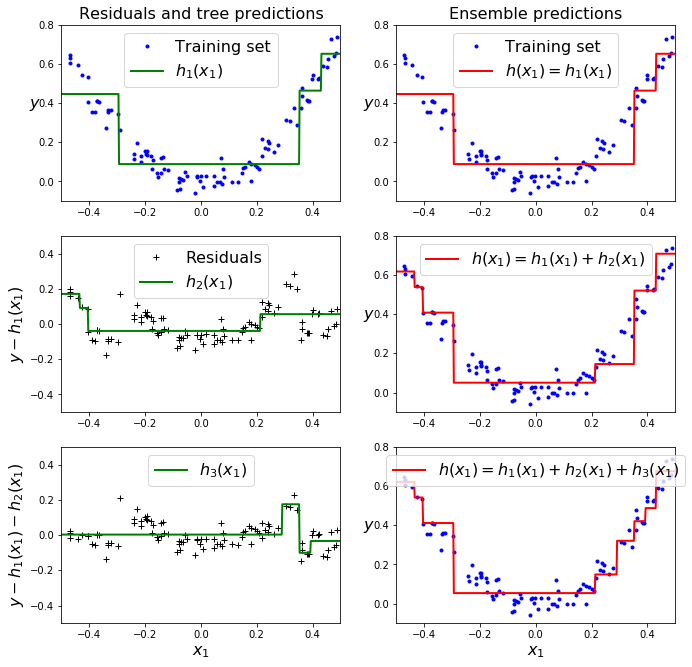

In [12]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0);

If we'd like to just create the ensemble, we can use sklearn's GradientBoostingRegressor. 

In [13]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y)

gbr = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

0.05874645540443007